In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.cm as cm
from scipy.interpolate import UnivariateSpline
import matplotlib.animation as animation
from shapely import wkt
from shapely import geometry
from shapely.geometry import Point
from matplotlib.patches import Polygon
from osmnx import utils_graph
import time as time

### Build Network

In [2]:
'''
Calculates capacities based on safe breaking distances and a paper from Moore et al (2013) 
and then appends this attributed to the graph G. [ code adapted from Mike Schimidt ]
'''

MOORE_AFTER_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [3.9, 6, 11, 18, 27, 39, 54, 58, 84],
)
MOORE_BEFORE_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [6, 8, 11, 14, 17, 19, 22, 25, 28],
)

MOORE_SAFE_BREAKING_DISTANCE = lambda x: MOORE_AFTER_BREAK_SPLINE(
    x
) + MOORE_BEFORE_BREAK_SPLINE(x)

#this uses the speed_kph attribute of the graph to calculate the moore capacities 
def moore(lanes: float, max_speed: float):
    return 1000 * max_speed / MOORE_SAFE_BREAKING_DISTANCE(max_speed) * lanes

'''
Adds capacities to multidigraph G using moore method from above [ code adapted from Mike Schimidt ]
'''
def add_capacities(G, method=moore):

    G = G.copy()
    cap = []
    
    for u, v, i in G.edges:
        edge_data = G.get_edge_data(u, v, i)
        raw_lanes = edge_data.get("lanes")
        
        if raw_lanes is None:
            lanes = 1
            
        elif isinstance(raw_lanes, str):
            lanes = int(raw_lanes) / 2  
            
        elif isinstance(raw_lanes, list):
            lanes = sum(int(x) for x in raw_lanes) / 2
            
        edge_data["capacity"] = int(method(lanes, edge_data["speed_kph"]))
        
        val = edge_data["capacity"]
        #print('val',val)
 
        cap.append(val)
    return (cap,G)

def init_flow(G):
    G = G.copy()
    
    for u, v, i in G.edges:
        edge_data = G.get_edge_data(u, v, i)
        edge_data["flow"] = 0
        
    return G

def init_edge_color(G):
    G = G.copy()
    
    for u, v, i in G.edges:
        edge_data = G.get_edge_data(u, v, i)
        edge_data["color"] = 'black'
        
    return G

'''
Building the Graph
'''
def build_graph(city_state, tol_amt):
#     to_crs='epsg:4326'
    G = ox.project_graph(ox.graph_from_place(city_state, network_type='drive'))
    G = ox.simplification.consolidate_intersections(G, tolerance=tol_amt, rebuild_graph=True, dead_ends=True, reconnect_edges = True)
    G = ox.speed.add_edge_speeds(G)
    G = ox.speed.add_edge_travel_times(G)
    edge_data,G =add_capacities(G)
    G = init_flow(G)
    G = init_edge_color(G)
    
    
    return G

### Using Networkx Functions for Making Residual Network

In [3]:
'''
Converting lat/longs to plot coordinates
'''

def proj_lat_lngs(lats, lngs, G):
    #convert lat and longs to point geometry
    pnts_list = [Point((lng, lat)) for lat, lng in zip(lats, lngs)]
    
    #convert list of points into Geoseries of points
    #(EPSG:4326 is WGS84)
    pnts = gpd.GeoSeries(pnts_list, crs='epsg:4326')
    
    #convert points to CRS from OSMNX projection
    proj_pnts = pnts.to_crs(G.graph['crs'])
    return proj_pnts

In [4]:
def remove_graph_polygon(G, polygon):
    ###find nodes inside poly to remove
    start_gs = time.process_time()
    gs_nodes = ox.utils_graph.graph_to_gdfs(G, edges=False)[["geometry"]]
    end_gs = time.process_time()
    print ("Time elapsed for gs: ", end_gs - start_gs)
    print("Number of Nodes from gs: ", len(gs_nodes))
#     to_remove = ox.utils_geo._intersect_index_quadrats(gs_nodes, polygon, quadrat_width, min_num)

###try intersection of halfspaces idea that steffen talked about
    to_remove = []
    start_to_remove = time.process_time()
    for point in gs_nodes['geometry']:
        ###currently this takes a long time to run, but a smaller polygon might make this run faster
        if point.within(polygon):
            node = ox.distance.nearest_nodes(G,point.x,point.y,return_dist=False)
            to_remove.append(node)
    end_to_remove = time.process_time()
    print ("Time elapsed for remove list: ", end_to_remove - start_to_remove)
     
    start_rem_net = time.process_time()      
    G = G.copy()
    G.remove_nodes_from(to_remove)
    end_rem_net = time.process_time()
    print ("Time elapsed for remove from net: ", end_rem_net - start_rem_net)

    return G



### Choose Source and Sink

In [5]:
##switch statement to choose origin and destination lat and long
def switch(key):
    if key == "Boulder":
        return (479800,4424260,489130,4429760)
    elif key == "Pueblo":
        return (5255180,4250280,514380,4423270)
    elif key == "Lyons":
        return (477230,4453570,476140,4430890)
    elif key == "Jefferson":
        return (489685,4379999,494940,4393420)
    elif key == "Sonoma":
        return (512007,4273277,525300,4255270)
    elif key == "Butte":
        return (621540,4406520,599230,4400090)
    else:
        raise Exception("Please enter a valid location.")
        exit()

df_sinks = pd.read_csv('optimal_sinks.csv')  
df_sources = pd.read_csv('sources.csv')
lat = [df_sinks['lat'][0],df_sources['lat'][0]]
long = [df_sinks['lon'][0],df_sources['lon'][0]]
        
###find nodes in network closestest to desired destinations
def s_t_nodes(network):
#     lat_start,long_start,lat_end,long_end = switch(location)
#     orig=ox.distance.nearest_nodes(network,lat_start,long_start,return_dist=False)
#     dest=ox.distance.nearest_nodes(network,lat_end,long_end,return_dist=False)
    df_sinks = pd.read_csv('optimal_sinks.csv')    
    df_sources = pd.read_csv('sources.csv')
    lat = [df_sinks['lat'][0],df_sources['lat'][0]]
    long = [df_sinks['lon'][0],df_sources['lon'][0]]
    proj_sink_source = proj_lat_lngs(lat, long, network)
    orig=ox.distance.nearest_nodes(network,proj_sink_source.x[1],proj_sink_source.y[1],return_dist=False)
    dest=ox.distance.nearest_nodes(network,proj_sink_source.x[0],proj_sink_source.y[0],return_dist=False)
    return orig, dest

In [6]:
'''
Finds "fastest" edge between 2 nodes based on attribute used for "fast"
Useful because have multidigraph, so multiple edges in same direction between nodes exist
'''
def fastest_edge(G,j,k,attr):
    ###find edge that was used in shortest path calculation
    fast_edge_attr = G[j][k][0][attr]
    fast_edge = 0
    if len(G.get_edge_data(j,k)) > 1:
        for m in range(1,len(G.get_edge_data(j,k))): 
            if G[j][k][m][attr] < fast_edge_attr:
                fast_edge_attr = G[j][k][m][attr]
                fast_edge = m
    return fast_edge

In [7]:
'''
Find Delta Flow for Path
'''
def delta_flow(G,path):
    caps = []
    for i in range(len(path)-1):
        j = path[i]
        k = path[i+1]
        
        ###find edge that was used in shortest path calculation
        m = fastest_edge(G,j,k,'travel_time')
        caps.append(G[j][k][m]['capacity'])

    delta = min(caps)
    return delta
            

In [110]:
'''
Augment Flow Along Path/Update Residual Network
'''
def update_resid(G,path,delta,G_orig):
    for i in range(len(path)-1):
        j = path[i]
        k = path[i+1]
        
        l = fastest_edge(G,j,k,'travel_time')
        updated = False
        
        if G_orig.get_edge_data(j,k) is not None:
            for n in range(len(G_orig.get_edge_data(j,k))):
                if nx.utils.edges_equal(G[j][k][l],G_orig[j][k][n]):
                    G_orig[j][k][l]['flow'] +=delta
                    updated = True
                    break;
        if updated == False:
            for n in range(len(G_orig.get_edge_data(k,j))):
                if nx.utils.edges_equal(G[j][k][l],G_orig[k][j][n]):
                    G_orig[k][j][l]['flow'] -=delta
                    break;
                    
            
        if G[j][k][l]['capacity']-delta == 0:
            attrs = G[j][k][l]
            keys = attrs.keys()
            if G.has_edge(k,j)==False:
                G.remove_edge(j,k,l)
                G.add_edge(k,j)
                for m in keys:
                    G[k][j][0][m]=attrs[m]
                G[k][j][0]['capacity']=delta
            else:
                for n in range(len(G.get_edge_data(k,j))):
                    if nx.utils.edges_equal(G[j][k][l],G[k][j][n]):
                        G.remove_edge(j,k,l)
                        G[k][j][n]['capacity'] +=delta
                        break;
                    if G[j][k][l] is not None:
                        G.remove_edge(j,k,l)
                        G.add_edge(k,j)
                        for m in keys:
                            G[k][j][len(G.get_edge_data(k,j))-1][m]=attrs[m]
                        G[k][j][len(G.get_edge_data(k,j))-1]['capacity']=delta
        else:
            G[j][k][l]['capacity'] -=delta
            attrs = G[j][k][l]
            keys = attrs.keys()
            if G.has_edge(k,j)==False:
                G.add_edge(k,j)
                for m in keys:
                    G[k][j][0][m]=attrs[m]
                G[k][j][0]['capacity']=delta
            else:
                for n in range(len(G.get_edge_data(k,j))):
                    if nx.utils.edges_equal(G[j][k][l],G[k][j][n]):
                        G[k][j][n]['capacity'] +=delta
                        break;
                    if G[j][k][l] is not None:
                        G.add_edge(k,j)
                        for m in keys:
                            G[k][j][len(G.get_edge_data(k,j))-1][m]=attrs[m]
                        G[k][j][len(G.get_edge_data(k,j))-1]['capacity']=delta

    return G


### Generic Augmenting Path Algorithm

In [289]:
###build network
net = build_graph('Butte California', 10)
#make a copy for plotting purposes
net_original=net.copy()

'''
Create Fire Polygon
'''
#Take in a set of lat and long coordinates (manual entry)
# lats = [39.6452, 39.4354, 39.6463]
lats = [39.734648034346534, 39.68350838633692, 39.712268854637365,39.76111104919261,39.778461493546175]
# lngs = [-121.4033,-121.5380, -121.8]
lngs = [-121.78664809835622,-121.72918902514293,-121.67533026689257, -121.66297064746938,-121.7332230678133]
#Take in lat and long from csv file TBD

#convert points to correct coordinate system
pointList = proj_lat_lngs(lats,lngs,net)

#create polygon from projected points
poly = geometry.Polygon([[p.x, p.y] for p in pointList])


###remove fire polygon first
net = remove_graph_polygon(net,poly)
###make copy of network without polygon for plotting purposes
net_polygon=net.copy()


###set origin and destination
orig,dest=s_t_nodes(net)

###amount to be sent
# pop = 10000
### list to stort shortest paths
paths = []

###GAP Algorithm
##find shortest path
shortest_path=ox.distance.shortest_path(net, orig, dest, weight='travel_time')
    
while shortest_path is not None:
    
    if shortest_path is not None:
        paths.append(shortest_path)
        
        ##find flow
        delta = delta_flow(net,shortest_path)
    
        ##update residual network
        net = update_resid(net,shortest_path,delta,net_original)
    else:
        break
        
    shortest_path=ox.distance.shortest_path(net, orig, dest, weight='travel_time')

Time elapsed for gs:  1.421875
Number of Nodes from gs:  12919
Time elapsed for remove list:  15.65625
Time elapsed for remove from net:  0.890625


### Plotting Functions

In [299]:
H = nx.Graph(((u, v, e) for u,v,e in net_original.edges(data=True) if e['flow'] != 0),crs = net_original.graph['crs'])

In [300]:
net_copy = net_original.copy()
net_copy.remove_nodes_from(n for n in net_original if n not in H)
net_copy.remove_edges_from(e for e in net_original.edges if e not in H.edges)

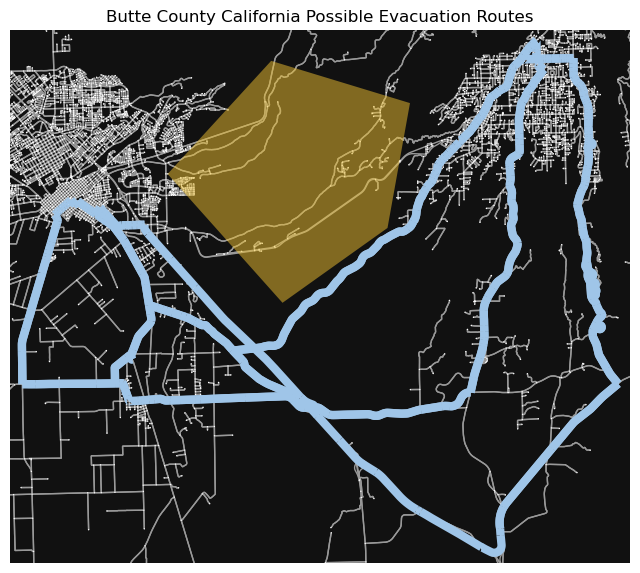

In [302]:
ec = ox.plot.get_edge_colors_by_attr(net_copy, attr="flow",cmap = "cool",num_bins = 10)
fig,ax = ox.plot_graph(net_original,show = False, close = False,node_size = 1)
ox.plot_graph(net_copy,node_color = '#9fc5e8ff',edge_color = '#9fc5e8ff',node_size=1,edge_linewidth=6,show = False, close = False, ax = ax)
x,y = poly.exterior.xy
ax.fill(x,y,'#f1c232ff', alpha = 0.5)
ax.set_title("Butte County California Possible Evacuation Routes")
plt.show()
fig.savefig('Butte_County_Evac_Routes.png')

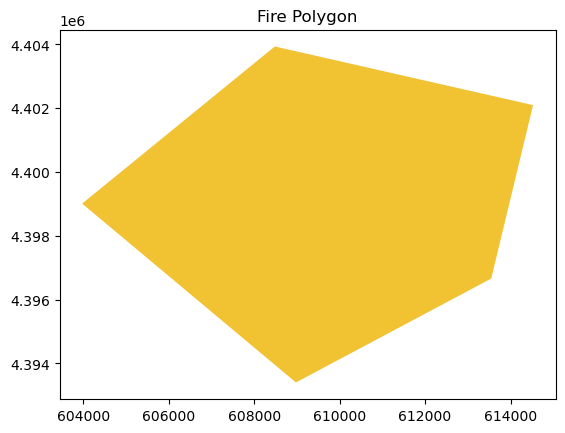

In [310]:
# lats = [39.6452, 39.4354, 39.6463]
lats = [39.734648034346534, 39.68350838633692, 39.712268854637365,39.76111104919261,39.778461493546175]
# lngs = [-121.4033,-121.5380, -121.8]
lngs = [-121.78664809835622,-121.72918902514293,-121.67533026689257, -121.66297064746938,-121.7332230678133]
#Take in lat and long from csv file TBD

#convert points to correct coordinate system
pointList = proj_lat_lngs(lats,lngs,net)

#create polygon from projected points
poly = geometry.Polygon([[p.x, p.y] for p in pointList])


x,y = poly.exterior.xy
plt.title("Fire Polygon")
plt.fill(x,y,'#f1c232ff')
plt.savefig('Fire_Polygon.png')
plt.show()

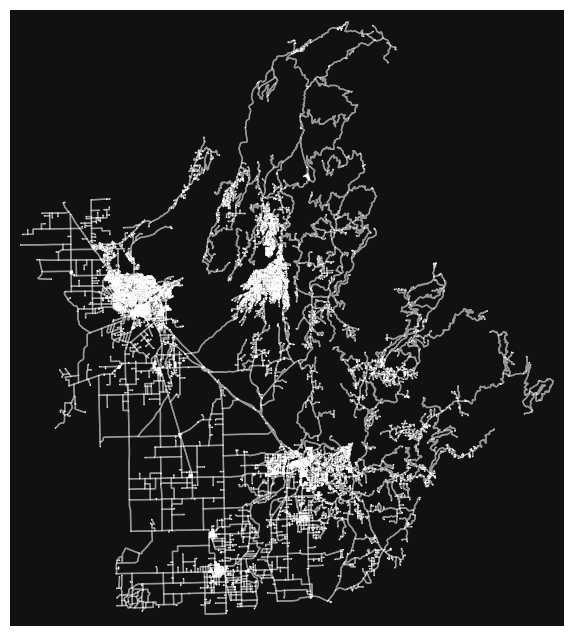

In [312]:
fig,ax = ox.plot_graph(net_polygon,show = False, close = False,node_size = 1)
fig.savefig('Network_with_Edges_Removed.png')

In [ ]:
'''
Gets n evenly spaced colors to map the different path with from the colormap 'hsv'
'''

def get_colors(n, cmap='hsv', start=0., stop=1., alpha=1.):

    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return colors

In [245]:
'''
Plotting Things
'''
def plotting(G, **kwargs):
    sp_list = kwargs.get('sp_list',[])
    poly = kwargs.get('poly',None)
    
    if len(sp_list)>0:
        if len(sp_list)>1:
            #colors for paths in plot
            cl = np.array(ox.plot.get_colors(len(sp_list),cmap = "plasma",return_hex = True))
            #plotting paths from GAP
            fig, ax = ox.plot_graph_routes(G, sp_list, route_colors=cl, route_linewidth=6, node_size=2, show = False, close = False, bgcolor = "#111111")
        else:
            fig, ax = ox.plot_graph_route(G, sp_list[0], route_color='y', route_linewidth=6, node_size=2, show = False, close = False,bgcolor = "#111111")
    if poly is not None:
            #pulling x,y coordinates from polyhedron
            x,y = poly.exterior.xy
            #plotting polyhedron
            ax.fill(x,y,'r', alpha = 0.3)     
    if len(sp_list)==0 and poly is None:
        #plot original network only
        ox.plot_graph(G,node_size = 1,edge_color = '#111111')

    plt.show()

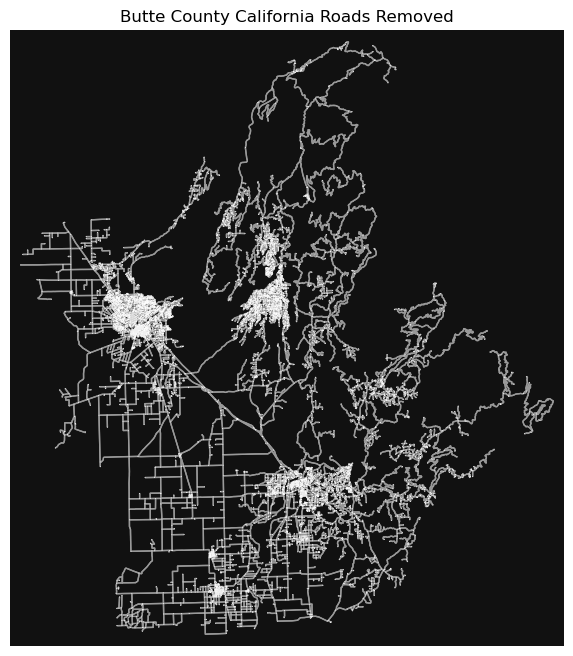

In [292]:
# bbox = ox.utils_geo.bbox_from_point((39.6452,-121.4033), dist=5000)
fig,ax = ox.plot_graph(net_polygon,node_size = 0.5,show = False, close = False)
# ax.fill(x,y,'#f1c232ff', alpha=0.5)
ax.set_title("Butte County California Roads Removed")
plt.show()
fig.savefig('Butte_County_Fire_Removed.png')

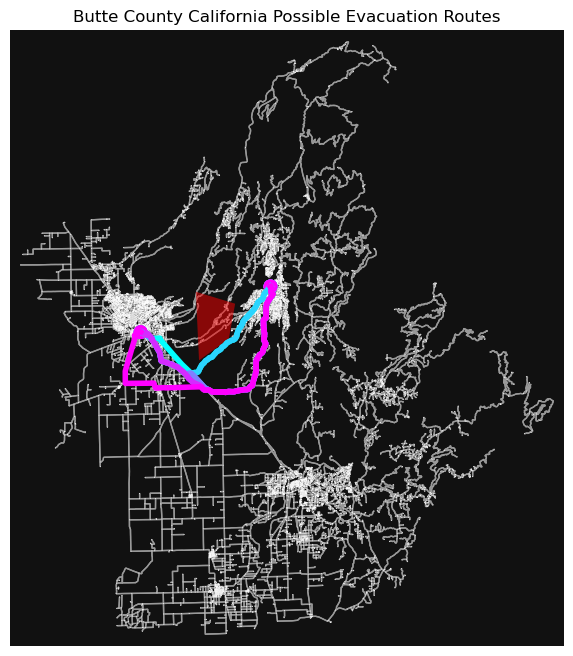

In [104]:
h = 7
# plotting(net_polygon,sp_list = paths,poly = poly)
#colors for paths in plot
cl = np.array(ox.plot.get_colors(len(paths[:h]),cmap = "cool",return_hex = True))
#plotting paths from GAP
# fig,ax = ox.plot_graph(net_original,node_size = 0.5,show = False, close = False)
# ax.set_title("Butte County California")
fig, ax = ox.plot_graph_routes(net_original, paths[:h], route_colors=cl, route_linewidth=8, node_size=0.5, show = False, close = False, route_alpha = 1)
#pulling x,y coordinates from polyhedron
x,y = poly.exterior.xy
#plotting polyhedron
# plt.plot(x,y,color = 'red',linewidth = 2, fillstyle = 'full')
ax.fill(x,y,'r', alpha = 0.5)
ax.set_title("Butte County California Possible Evacuation Routes")
plt.show()
# fig.savefig('Butte_County_Evac_Routes.png')

### Testing Purposes, Please Ignore

In [ ]:
def add_flow(G,path_list,deltas):
    G = G.copy()
    for path in path_list:
#         delta = delta_flow(G, path)
        updated_path = []
    
        for i in range(len(path)-1):
            j = path[i]
            k = path[i+1]
            
            if G.get_edge_data(j, k, m) is None:
                path[i] = k
                path[i+1] = j
                
                m=fastest_edge(G,j,k,'travel_time')
                
            edge_data = G.get_edge_data(j, k, m)

            edge_data['flow'] = edge_data['flow']+delta
#             print('edge flow',j,k,edge_data["flow"])

    return G

In [98]:
def fix_paths(G,path_list):
    G = G.copy()
    for path in path_list:
#         delta = delta_flow(G, path)
        updated_path = []
    
        for i in range(len(path)-1):
            j = path[i]
            k = path[i+1]
            
            if G.get_edge_data(j, k) is None:
                
                
    return path_list

In [199]:
# paths[8]

In [101]:
path_8_copy = paths[8]

In [200]:
# print(path_8_copy)

In [94]:
fixed_path_8=fix_paths(net_original,[path_8_copy])

In [201]:
# print(fixed_path_8)

In [202]:
# print(net_original.get_edge_data(1873,438))

In [ ]:
net_flow = add_flow(net_original,paths)

In [160]:
# p = 1
# for u, v in zip(paths[p][:-1], paths[p][1:]):
# # for i in range(len(paths[9]))
#     # if there are parallel edges, select the shortest in length
#     print(u,v)
#     data = min(net_original.get_edge_data(u, v).values(), key=lambda d: d["length"])
#     if "geometry" in data:
#     # if geometry attribute exists, add all its coords to list
#         xs, ys = data["geometry"].xy

In [203]:
# bbox = ox.utils_geo.bbox_from_point((610385, 4403305), dist=5000)
# 

In [123]:
# edge_color=ec
# cmap = ox.plot.get_colors(n=5, cmap="cool", return_hex=True)
# conditions_2 = [(edges_df['counts']<=10),
#                   ((edges_df['counts']>10) & (edges_df['counts']<=20)),
#                   ((edges_df['counts']>20) & (edges_df['counts']<=30)),
#                   ((edges_df['counts']>30) & (edges_df['counts']<=40)),
#                    ((edges_df['counts']>40) & (edges_df['counts']<=70))]
#     vals = ['#0037C7','#5A82F3','#1EBED6','#FF5757','#FF0000'] #dark blue to dark red
#     edges_df['freq'] = np.select(conditions_2, vals)

df_flows = pd.DataFrame.from_dict(nx.get_edge_attributes(net_original, 'flow'),orient = 'index',columns = ['flow'])
conditions_2 = [(df_flows['flow']==0),
                  ((df_flows['flow']>0) & (df_flows['flow']<=200)),
                  ((df_flows['flow']>200) & (df_flows['flow']<=600)),
                  ((df_flows['flow']>400) & (df_flows['flow']<=600)),
                   ((df_flows['flow']>600) & (df_flows['flow']<=800)),
                   ((df_flows['flow']>800) & (df_flows['flow']<=1000)),
                   ((df_flows['flow']>1000) & (df_flows['flow']<=1200)),
                   ((df_flows['flow']>1200) & (df_flows['flow']<=1400)),
                   ((df_flows['flow']>1400) & (df_flows['flow']<=1600)),
                   ((df_flows['flow']>1600) & (df_flows['flow']<=1800)),
                   ((df_flows['flow']>1800) & (df_flows['flow']<=2000))]
vals = ['#Ffffff','#8f01ff','#0137ff','#0199ff','#01fbff','#01ff2d','#Abff01','#Ffd601','#Ffa901','#Ff7401','#Ff0101']
df_flows['color'] = np.select(conditions_2, vals)

ec = df_flows['color'].squeeze()

In [ ]:
# ec = ox.plot.get_edge_colors_by_attr(net_flow, attr="flow",num_bins = 5)

In [ ]:
# nx.get_edge_attributes(net_flow, 'flow').keys()


In [113]:
df_flows = pd.DataFrame.from_dict(nx.get_edge_attributes(net_original, 'flow'),orient = 'index',columns = ['flow'])

In [117]:
df_nonzero = df_flows.loc[df_flows['flow']!=0]

In [204]:
# max(df_nonzero['flow'])

In [161]:
# df_nonzero

In [59]:
net_original.get_edge_data(0,1)
net_original.add_edge(0,1)
len(net_original.get_edge_data(0,1))

3

In [162]:
# net_original.get_edge_data(0,1)

In [205]:
# H.get_edge_data(438,437)

In [206]:
# nx.draw(H,node_size=30)

In [197]:
# H_proj = ox.project_graph(H, to_crs=net_original.graph['crs'])
# H.edges(keys)
# list(H.nodes)

In [177]:
# edges_nodes = ox.utils_graph.graph_to_gdfs(net_original, edges=False)[['flow']]


In [183]:
# edges_nodes


In [198]:
# net_copy